In [1]:
import os 
import time 
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

import string 
from collections import Counter

In [2]:
writer = SummaryWriter(os.path.join("runs", "baby-names"))

# 1. Load Data

In [3]:
data_path = os.path.join("storage", "data", "baby-names", "NationalNames.csv")
data = pd.read_csv(data_path)
print(data.shape)
data.head()

(1825433, 5)


,Id,Name,Year,Gender,Count
0,1,Mary,1880,F,7065
1,2,Anna,1880,F,2604
2,3,Emma,1880,F,2003
3,4,Elizabeth,1880,F,1939
4,5,Minnie,1880,F,1746


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825433 entries, 0 to 1825432
Data columns (total 5 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Name    object
 2   Year    int64 
 3   Gender  object
 4   Count   int64 
dtypes: int64(3), object(2)
memory usage: 69.6+ MB


# 2. Clean Data

In [5]:
def clean(name):
    name = name.lower().strip()
    name = "".join([c for c in name if c in string.ascii_lowercase])
    name += "."
    return name

In [6]:
data["Name"] = data["Name"].apply(clean)
data.head()

,Id,Name,Year,Gender,Count
0,1,mary.,1880,F,7065
1,2,anna.,1880,F,2604
2,3,emma.,1880,F,2003
3,4,elizabeth.,1880,F,1939
4,5,minnie.,1880,F,1746


In [7]:
names = data[["Name", "Count"]].groupby("Name").sum()
#del names.index.name
print(len(names))
names.head()

93889


,Count
Name,
aaban.,72
aabha.,21
aabid.,5
aabriella.,10
aadam.,196


In [8]:
pd.Series(names.index).apply(len).max()

16

In [9]:
max_length = 11
len_filter = pd.Series(names.index).apply(lambda x: len(x) <= max_length).tolist()
print(len_filter[:10])
print(names.shape)
names = names[len_filter]
print(names.shape)

[True, True, True, True, True, True, True, True, True, True]
(93889, 1)
(92889, 1)


In [10]:
pd.Series(names.index).apply(len).max()

11

In [11]:
names = names.sort_values(by=["Count"], ascending=False)
names.head()

,Count
Name,
james.,5129096
john.,5106590
robert.,4816785
michael.,4330805
mary.,4130441


# 3. Set Training Data

In [12]:
names["Count"].describe()

count    9.288900e+04
mean     3.606536e+03
std      5.557699e+04
min      5.000000e+00
25%      1.100000e+01
50%      4.500000e+01
75%      2.400000e+02
max      5.129096e+06
Name: Count, dtype: float64

In [13]:
alpha = 0.8
names["Count"].apply(lambda x: np.power(x, alpha)).apply(np.int).describe()

C:\Users\User\AppData\Local\Temp\ipykernel_24364\3411911399.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  names["Count"].apply(lambda x: np.power(x, alpha)).apply(np.int).describe()


count     92889.000000
mean        342.499295
std        3211.942902
min           3.000000
25%           6.000000
50%          21.000000
75%          80.000000
max      233363.000000
Name: Count, dtype: float64

In [14]:
names["count_normalized"] = names["Count"].apply(lambda x: np.power(x, alpha)).apply(np.int)
names.head()

C:\Users\User\AppData\Local\Temp\ipykernel_24364\1420255283.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  names["count_normalized"] = names["Count"].apply(lambda x: np.power(x, alpha)).apply(np.int)


,Count,count_normalized
Name,,
james.,5129096,233363
john.,5106590,232543
robert.,4816785,221924
michael.,4330805,203823
mary.,4130441,196244


In [15]:
count_normalized_sum = names["count_normalized"].sum()
print(count_normalized_sum)

31814417


In [16]:
names["p"] = names["count_normalized"] / count_normalized_sum
names.head()

,Count,count_normalized,p
Name,,,
james.,5129096,233363,0.007335
john.,5106590,232543,0.007309
robert.,4816785,221924,0.006976
michael.,4330805,203823,0.006407
mary.,4130441,196244,0.006168


In [17]:
np.random.seed(0)
names_list = np.random.choice(names.index, size=10**5, p=names["p"], replace=True)
print(len(names_list))
print(names_list[:50])

100000
['joanna.' 'pearlie.' 'harrison.' 'kay.' 'kim.' 'braden.' 'bernard.'
 'eugena.' 'essynce.' 'audrey.' 'sharla.' 'oliver.' 'susie.' 'meka.'
 'patricia.' 'donald.' 'robert.' 'sheyla.' 'lizeth.' 'tayden.' 'casmira.'
 'karmen.' 'dean.' 'danita.' 'ronald.' 'mona.' 'frank.' 'kareemah.'
 'mackenzie.' 'thelma.' 'grace.' 'kami.' 'gertrude.' 'misty.' 'robert.'
 'horace.' 'gerard.' 'salvatore.' 'iyannah.' 'hillary.' 'edna.' 'holly.'
 'simone.' 'thomas.' 'ronda.' 'helena.' 'katherine.' 'helen.' 'madison.'
 'dawn.']


In [18]:
pd.Series(names_list).value_counts()

james.      733
john.       724
robert.     677
michael.    649
william.    605
           ... 
kiswana.      1
meko.         1
letzy.        1
dedrick.      1
oramae.       1
Name: count, Length: 16785, dtype: int64

In [19]:
del data, names

# 4. Define Utilities

In [20]:
chars = "." + string.ascii_lowercase
num_chars = len(chars)
print(chars)
print(num_chars)

.abcdefghijklmnopqrstuvwxyz
27


In [21]:
char_to_id = {c:i for i,c in enumerate(chars)}
id_to_char = {v:k for k,v in char_to_id.items()}
print(char_to_id)
print(id_to_char)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [22]:
print(max_length)

11


# 5. Define Dataset

In [23]:
class NamesDataset(Dataset):
    def __init__(self, names_list):
        self.names_list = names_list

    def __len__(self):
        self.len = len(self.names_list)
        return self.len
    
    def __getitem__(self, idx):
        x_str = self.names_list[idx].ljust(max_length, ".")[:max_length]
        y_str = x_str[1:] + "."
        x = torch.zeros((max_length, num_chars))
        y = torch.zeros(max_length)
        for i, c in enumerate(x_str):
            x[i, char_to_id[c]] = 1
        for i, c in enumerate(y_str):
            y[i] = char_to_id[c]
        return x,y
                        

In [24]:
trainset = NamesDataset(names_list)

# 6. Define DataLoader

In [25]:
train_batch_size = 256

In [26]:
cpu_count = os.cpu_count()
print(cpu_count)

8


In [27]:
train_loader = DataLoader(trainset, batch_size=train_batch_size, shuffle=True, num_workers=0)
print(len(train_loader))

391


In [28]:
train_iter = iter(train_loader)
X, Y = train_iter.__next__()
print(X.size(), Y.size())

torch.Size([256, 11, 27]) torch.Size([256, 11])


# 7. Define Model

In [29]:
input_size = num_chars
hidden_size = 54
output_size = num_chars
num_layers = 1

In [30]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

In [31]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.fc3 = nn.Linear(output_size, output_size)

    def forward(self, X, states):
        ht, ct = states
        batch_size = X.size(0)
        out, (ht, ct) = self.lstm1(X, (ht, ct))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out, (ht, ct)

In [32]:
model = Model(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers)
model = nn.DataParallel(model)
model = model.to(device)

In [33]:
ht = torch.zeros((num_layers, train_batch_size, hidden_size)).to(device)
ct = torch.zeros((num_layers, train_batch_size, hidden_size)).to(device)
writer.add_graph(model, (X, (ht, ct)))
writer.close()

# 8. Set Optimizer

In [34]:
lr = 0.005
step_size = len(train_loader) * 1
gamma = 0.95
print(step_size)

391


In [35]:
criterion = nn.CrossEntropyLoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma)

# 9. Define Sampler

In [36]:
def generate_name(model, start='a', k=5):
    
    if len(start) >= max_length:
        return name

    with torch.no_grad():
        ht = torch.zeros((num_layers, 1, hidden_size)).to(device)
        ct = torch.zeros((num_layers, 1, hidden_size)).to(device)
        length = 0 
        name = start

        for char in start:
            X = torch.zeros((1, 1, num_chars))
            X[0, 0, char_to_id[char]] = 1
            out, (ht, ct) = model(X, (ht, ct))
            length += 1

        vals, idxs = torch.topk(out[0], k)
        idx = np.random.choice(idxs.cpu().numpy()[0])
        char = id_to_char[idx]
        vals, idxs = torch.topk(out[0], k)
        idx = np.random.choice(idxs.cpu().numpy()[0])
        char = id_to_char[idx]

        while char != "." and length <= max_length-1:
            X = torch.zeros((1, 1, num_chars))
            X[0, 0, char_to_id[char]] = 1
            out, (ht, ct) = model(X, (ht, ct))
            vals, idxs = torch.topk(out[0], k)
            idx = np.random.choice(idxs.cpu().numpy()[0])
            char = id_to_char[idx]
            length += 1 
            name += char
        
        if name[-1] != ".":
            name += "."

    return name

In [37]:
def sampler(model, start='a', n=10, k=5, only_new=False):

    names = []
    cnt = 0
    while cnt <= n:
        name = generate_name(model=model, start=start, k=k)
        if only_new:
            if name not in names_list and name not in names:
                names.append(name)
                cnt += 1
        else:
            if name not in names:
                names.append(name)
                cnt += 1
    names = [name[:-1].title() for name in names]

    return names 

# 10. Train Model 

In [38]:
epochs = 50 
print_every_n_epochs = epochs // 10

In [40]:
epoch_losses = []
epoch_lrs = []
iteration_losses = []
iteration_lrs = []

for epoch in tqdm(range(1, epochs+1), desc="Epochs"):
    epoch_loss = 0
    epoch_lr = 0

    for i, (X,Y) in tqdm(enumerate(train_loader, 1), total=len(train_loader), desc=f"Epoch-{epoch}"):
        X,Y = X.to(device), Y.to(device)
        ht = torch.zeros((num_layers, X.size(0), hidden_size)).to(device)
        ct = torch.zeros((num_layers, X.size(0), hidden_size)).to(device)

        optimizer.zero_grad()
        Y_pred_logits, (ht,ct) = model(X, (ht,ct))
        Y_pred_logits = Y_pred_logits.transpose(1, 2)
        loss = criterion(Y_pred_logits, Y.long())
        loss.backward(retain_graph=True)
        optimizer.step()
        lr_scheduler.step()

        iteration_losses.append(loss.item())
        iteration_lrs.append(lr_scheduler.get_lr()[0])
        epoch_loss += loss.item()
        epoch_lr += lr_scheduler.get_lr()[0]

    epoch_loss /= len(train_loader)
    epoch_lr /= len(train_loader)
    epoch_losses.append(epoch_loss)
    epoch_lrs.append(epoch_lr)

    if epoch % print_every_n_epochs == 0:
        message = f"Epoch:{epoch}     Loss:{epoch_loss}       LR:{epoch_lr}"
        print(message) 
        names = sampler(model=model, start='jo', n=10, k=10, only_new=False)
        print(names)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch-1:   0%|          | 0/391 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\Dekalog\Lib\site-packages\torch\optim\lr_scheduler.py:402: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch-2:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-3:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-4:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-5:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch:5     Loss:0.7219701387998089       LR:0.004071515721107749
['Jofyll', 'Joakae', 'Jomoueantha', 'Joo', 'Jodonewoldo', 'Jonalovioua', 'Jolewarnyoa', 'Joophanonia', 'Jomu', 'Joovisysey', 'Jogytiun']


Epoch-6:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-7:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-8:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-9:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch:10     Loss:0.6531286177122989       LR:0.00315046125172471
['Jo', 'Joelzioovil', 'Jouf', 'Joduaphiapi', 'Joat', 'Jonold', 'Jomuseciots', 'Joaloreszyo', 'Jom', 'Joyappo', 'Johladey']


Epoch-11:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-12:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-13:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-14:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-15:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch:15     Loss:0.6314073436705353       LR:0.0024377668609169767
['Jorsus', 'Joicpseiga', 'Jonynnsietn', 'Joyape', 'Jodielosaur', 'Joifheuhtez', 'Joll', 'Joiyesenty', 'Jo', 'Jomikoohies', 'Jonc']


Epoch-16:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-17:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-18:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-19:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-20:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch:20     Loss:0.6201716342850414       LR:0.0018862975270467594
['Jomool', 'Jozo', 'Jorlp', 'Joanni', 'Jodoxshessa', 'Jotourwyziu', 'Jodf', 'Jomtylmow', 'Joueon', 'Joguemsione', 'Jouesseelvy']


Epoch-21:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-22:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-23:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-24:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch:25     Loss:0.6130932834752075       LR:0.0014595810688821825
['Jozslakkoy', 'Joztose', 'Joatsouhesm', 'Jov', 'Jodyhpe', 'Jobrr', 'Joahlaophob', 'Jo', 'Jomoaleeelm', 'Jomaanisahk', 'Jodinseeyaw']


Epoch-26:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-27:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-28:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-29:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-30:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch:30     Loss:0.6083635160380312       LR:0.001129396007836903
['Josetsisiel', 'Jomho', 'Jo', 'Joppai', 'Joduspuz', 'Jodrifferny', 'Jodetowyiea', 'Jody', 'Jotp', 'Jochayrrri', 'Jouam']


Epoch-31:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-32:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-33:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-34:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch:35     Loss:0.6048577219019156       LR:0.0008739051017528039
['Jouesigldul', 'Joaulosyal', 'Jozulzicaug', 'Jo', 'Jowads', 'Jodifofdlua', 'Jousawaaubu', 'Josllllishy', 'Joesussh', 'Jonordsulyv', 'Jonclasa']


Epoch-36:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-37:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-38:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-39:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-40:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch:40     Loss:0.6023738593091745       LR:0.0006762111089203196
['Jo', 'Josunlyving', 'Jodwernicko', 'Jodouso', 'Joahlie', 'Jovhuasehkh', 'Joezolmahkl', 'Jogetasoyth', 'Jodbbonachh', 'Jounsa', 'Joettioulos']


Epoch-41:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-42:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-43:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-44:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-45:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch:45     Loss:0.6004751690513338       LR:0.0005232392658082784
['Jo', 'Jopum', 'Jonespwynom', 'Jovilovapel', 'Jocionck', 'Joi', 'Joynesyoyus', 'Jotu', 'Jovunoyzhau', 'Joorlaa', 'Joiahellosy']


Epoch-46:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-47:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-48:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-49:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch:50     Loss:0.5989174824541487       LR:0.0004048725696339396
['Jouugl', 'Joksylehala', 'Jonsuklmndr', 'Joepiriruru', 'Jomahllyowh', 'Joiylawstwi', 'Joeemhra', 'Jol', 'Jonaedahwwy', 'Jomi', 'Jorldinyl']


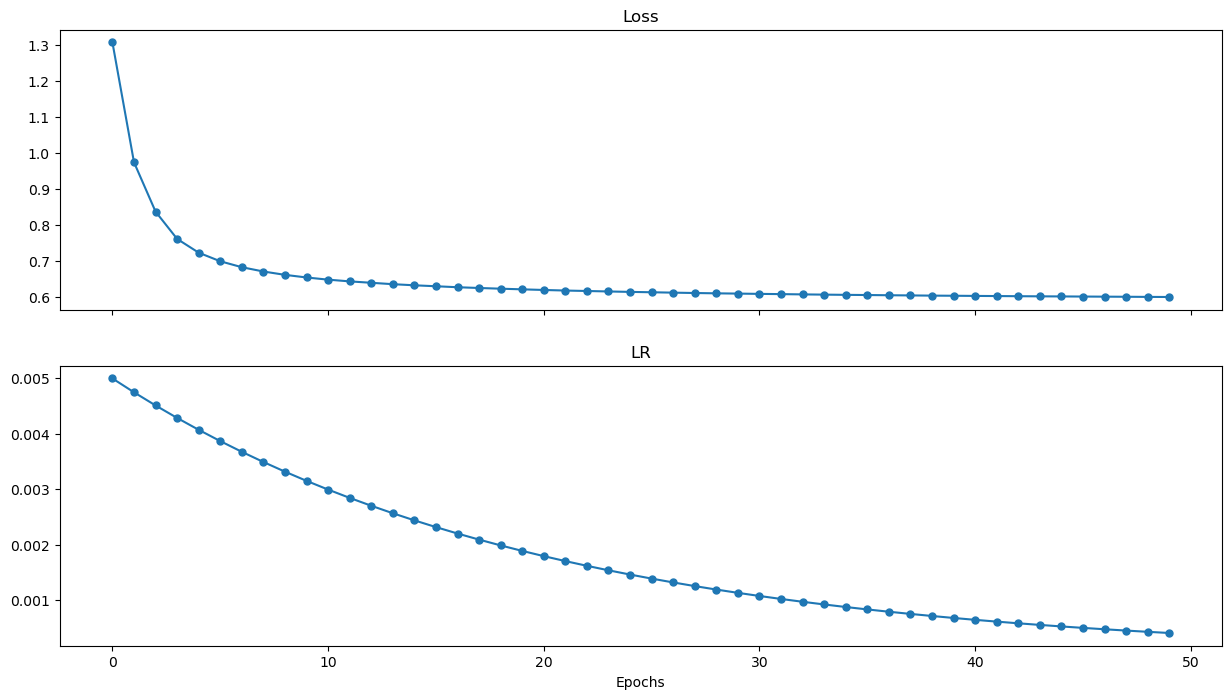

In [41]:
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, figsize=(15,8))
ax1.plot(epoch_losses, marker="o", markersize=5)
ax1.set_title("Loss")
ax2.plot(epoch_lrs, marker="o", markersize=5)
ax2.set_title("LR")
plt.xlabel("Epochs")
plt.show()

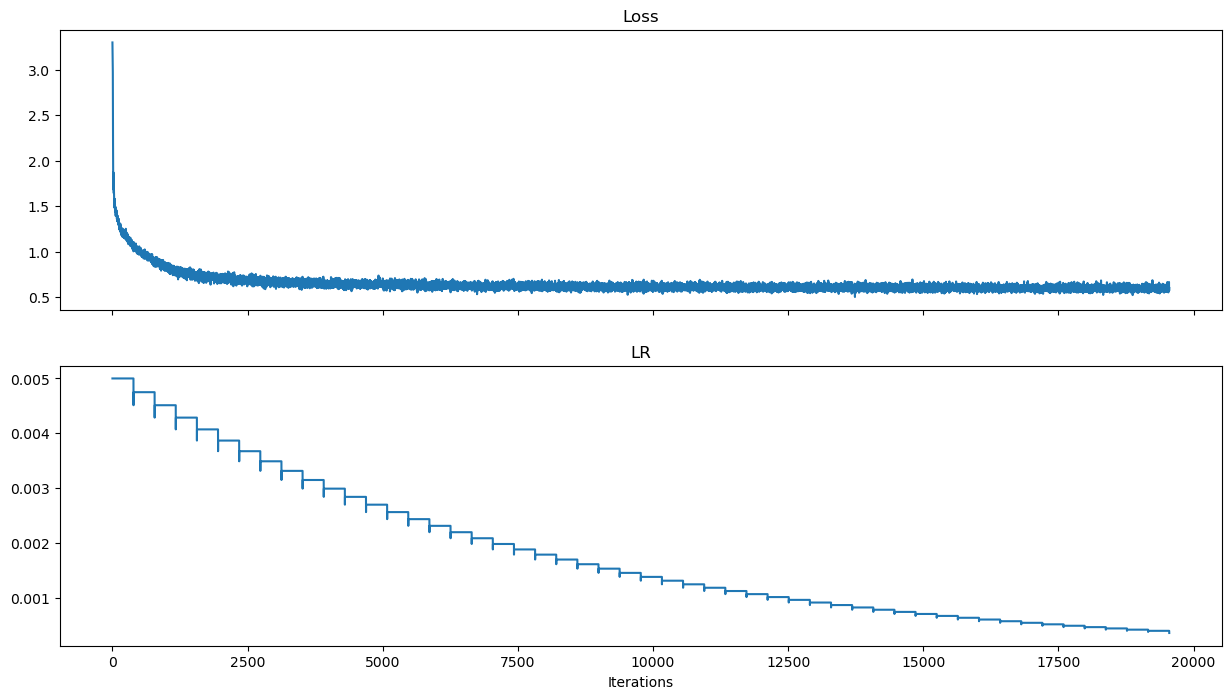

In [42]:
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(15,8))
ax1.plot(iteration_losses[::]) 
ax1.set_title("Loss")
ax2.plot(iteration_lrs[::])
ax2.set_title("LR")
plt.xlabel("Iterations")
plt.show()

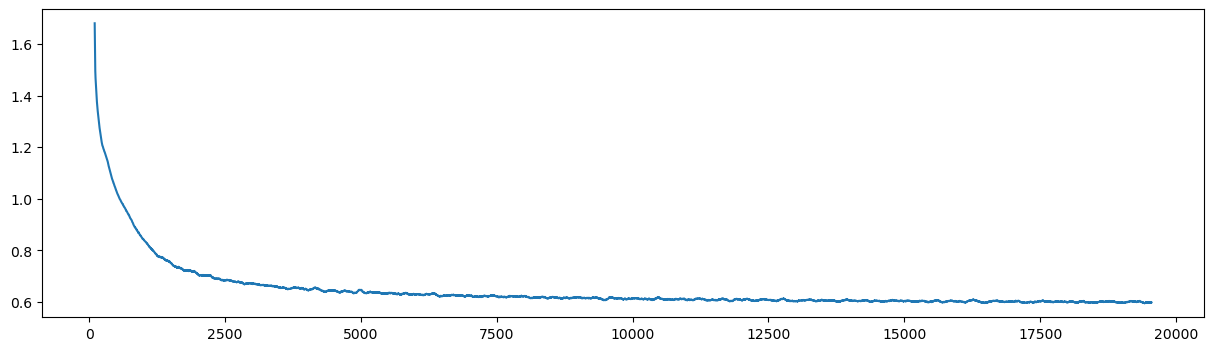

In [43]:
window = 100
plt.figure(figsize=(15,4))
pd.Series(iteration_losses).rolling(window=window).mean().iloc[window-1:].plot()
plt.show()

In [44]:
path = os.path.join("storage", "models", "baby-names", "classifier.pth")
torch.save(model.state_dict(), path)

# 11. Generate Baby Names

In [45]:
path = os.path.join("storage", "models", "baby-names", "classifier.pth")
model = Model(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers)
model = nn.DataParallel(model)
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [46]:
names = sampler(model=model, start="indi", n=10, k=5, only_new=True)
print(names)

['Indi', 'Indimueliee', 'Indil', 'Indiiausahh', 'Indilaare', 'Indihamanh', 'Indiellaw', 'Indimou', 'Indihhm', 'Indinohtawn', 'Indih']


In [47]:
names = sampler(model=model, start="herb", n=10, k=5, only_new=False)
print(names)

['Herban', 'Herbeee', 'Herbylonet', 'Herbnn', 'Herbtteirah', 'Herbl', 'Herbero', 'Herbrdolian', 'Herbye', 'Herbr', 'Herbt']


In [48]:
names = sampler(model=model, start="su", n=10, k=5, only_new=True)
print(names)

['Suottyaundr', 'Suma', 'Sudyyomanys', 'Suny', 'Suntahi', 'Suow', 'Sueyneseeal', 'Suounasdell', 'Suena', 'Suerythow', 'Suani']


In [49]:
names = sampler(model=model, start="vis", n=10, k=5, only_new=True)
print(names)

['Visanys', 'Visiaus', 'Viseemmitae', 'Visiamhiemh', 'Visanee', 'Visiuroulin', 'Viserteusel', 'Visanna', 'Visrceetami', 'Visyhilowda', 'Vise']


In [50]:
names = sampler(model=model, start="a", n=10, k=3, only_new=True)
print(names)

['Aexia', 'Athiur', 'Adysonienee', 'Alador', 'Alian', 'Aiett', 'Aietne', 'Atoinet', 'Ainaa', 'Ainah', 'Athuraine']


In [51]:
names = sampler(model=model, start="a", n=10, k=8, only_new=True)
print(names)

['Ayneallicom', 'Agispa', 'Atronzyahum', 'Aan', 'Ancrel', 'Am', 'Alydoepwecd', 'Aitrio', 'Aieme', 'Aiagh', 'Aisyzn']


In [52]:
names = sampler(model=model, start="a", n=10, k=15, only_new=True)
print(names)

['Aazyidyimpa', 'Axrvirwryua', 'Acpzedlpuok', 'Ar', 'Albi', 'Aeeyewtyikp', 'Aorniolnica', 'Avhdnaettae', 'Arkyndsznou', 'Aatiungdvli', 'Avnaa']


In [53]:
names = sampler(model=model, start="jam", n=10, k=2, only_new=False)
print(names)

['Jame', 'Jamson', 'Jams', 'Jaml', 'Jamllahnahn', 'Jamer', 'Jamlla', 'Jamso', 'Jamlle', 'Jamsone', 'Jamsony']
